In [1]:
#Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
#Set Parameters here
epochs = 500000
batch_size = 1000
train_points = 1000 # 60k total training examples, 10k test examples
test_points = 1000
lr = 0.001
weight_decay = 0.01
initialization_scale = 8.0
#Optmization steps should be train_points/batchsize * epochs 
print(train_points/batch_size * epochs)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


500000.0


In [3]:
#Network Structure
class WineClassification(nn.Module):
    def __init__(self):
        super(WineClassification, self).__init__()
        width = 200
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(11, width).to(device)
        self.fc2 = nn.Linear(width, width).to(device)
        self.fc3 = nn.Linear(width, 10).to(device)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = WineClassification().to(device)


with torch.no_grad(): 
    for p in model.parameters(): 
        p.data = initialization_scale * p.data

In [4]:
data = pd.read_csv('wine+quality/winequality-white.csv', delimiter=';') 
X = data.drop('quality', axis=1).values
y = data['quality'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Standardize the data 
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create TensorDataset and DataLoader 
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor) 
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor) 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader)) 
print(len(test_loader))

1
5


Epoch [10000/500000], Loss: 0.0055, Train Accuracy: 1.0000, Val Accuracy: 0.1570, Weight Norm: 150.8270:   2%|▏         | 9996/500000 [04:25<3:13:02, 42.31it/s]

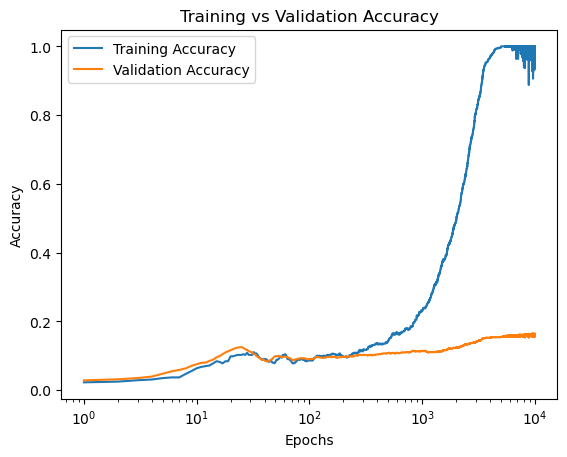

Epoch [20000/500000], Loss: 0.0056, Train Accuracy: 1.0000, Val Accuracy: 0.1731, Weight Norm: 135.8603:   4%|▍         | 19996/500000 [08:57<3:32:08, 37.71it/s]

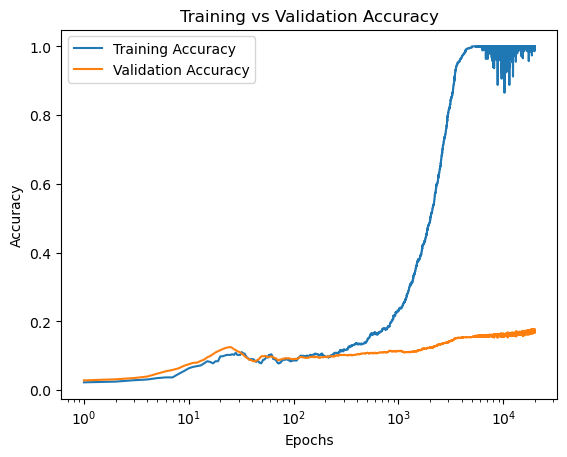

Epoch [30000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.1878, Weight Norm: 122.3160:   6%|▌         | 29999/500000 [13:26<3:49:01, 34.20it/s]

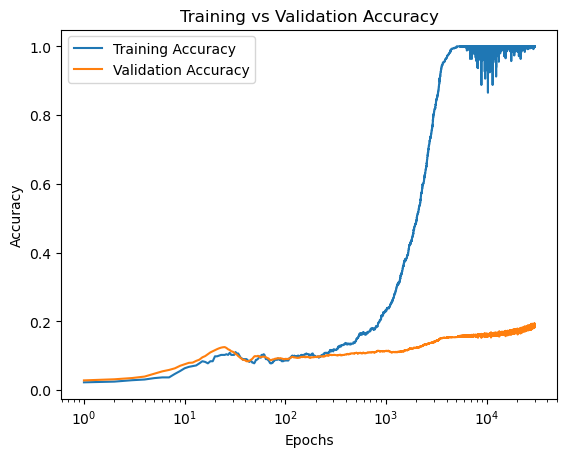

Epoch [40000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.2057, Weight Norm: 110.1078:   8%|▊         | 39995/500000 [17:54<3:28:10, 36.83it/s]

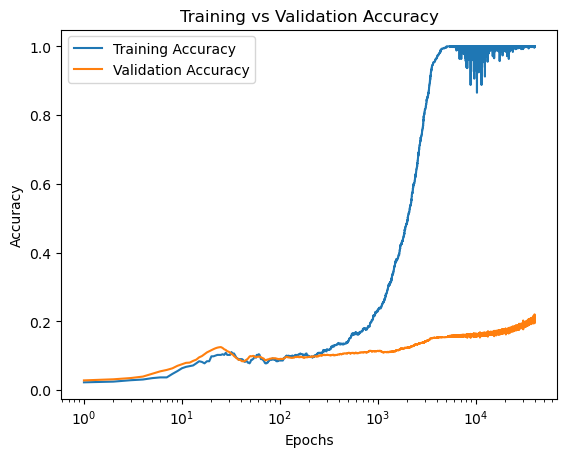

Epoch [50000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.2472, Weight Norm: 99.1951:  10%|▉         | 49995/500000 [22:17<3:08:12, 39.85it/s] 

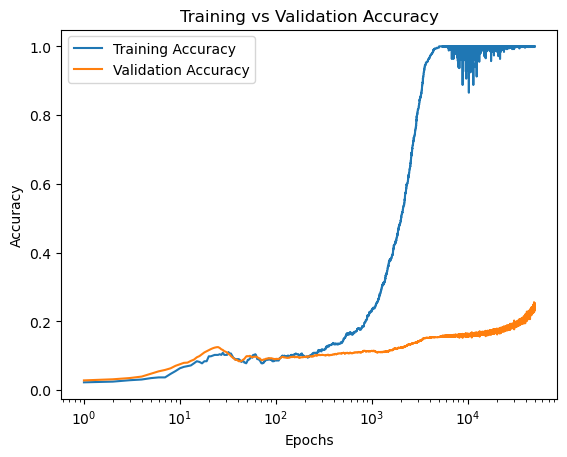

Epoch [60000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.2983, Weight Norm: 89.5921:  12%|█▏        | 59996/500000 [26:43<3:55:22, 31.16it/s]

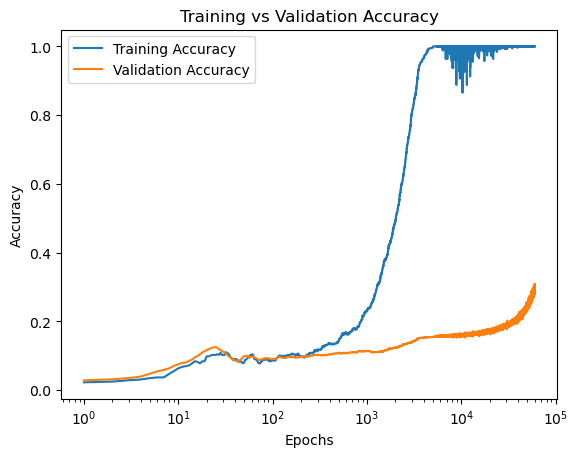

Epoch [70000/500000], Loss: 0.0003, Train Accuracy: 1.0000, Val Accuracy: 0.3536, Weight Norm: 81.3156:  14%|█▍        | 69998/500000 [31:37<2:55:47, 40.77it/s]

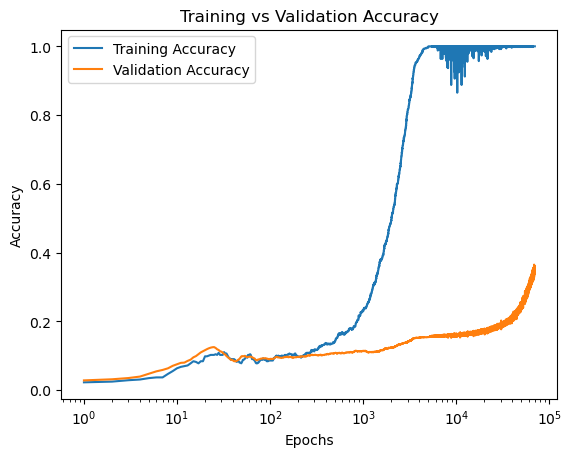

Epoch [80000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4085, Weight Norm: 74.5024:  16%|█▌        | 79997/500000 [36:27<3:34:44, 32.60it/s]

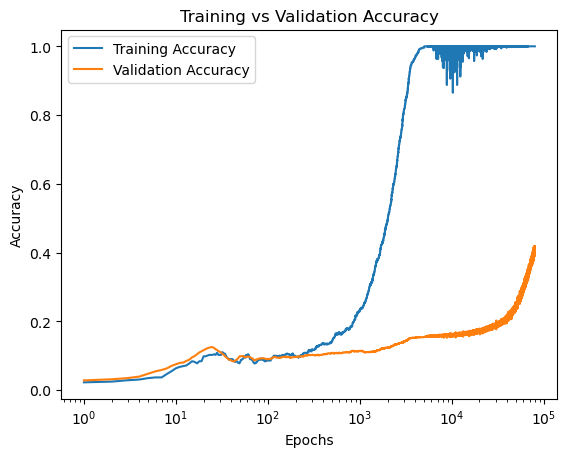

Epoch [90000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4439, Weight Norm: 69.0375:  18%|█▊        | 89996/500000 [41:15<3:51:30, 29.52it/s]

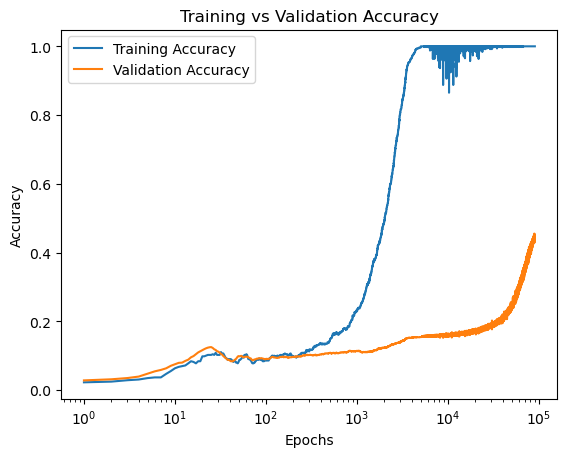

Epoch [100000/500000], Loss: 0.0003, Train Accuracy: 1.0000, Val Accuracy: 0.4711, Weight Norm: 64.8165:  20%|█▉        | 99996/500000 [46:56<4:06:26, 27.05it/s]

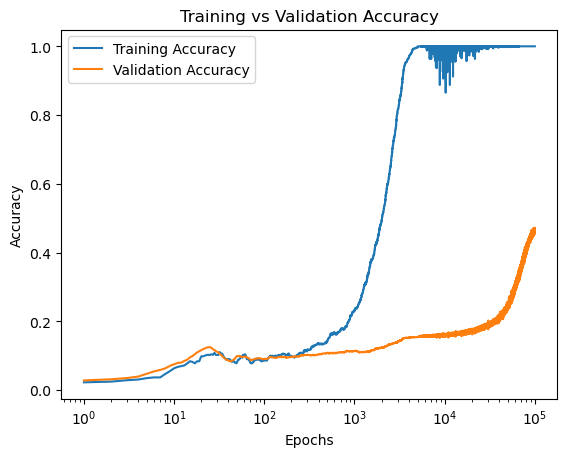

Epoch [110000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4799, Weight Norm: 61.5673:  22%|██▏       | 109997/500000 [52:34<3:31:37, 30.72it/s]

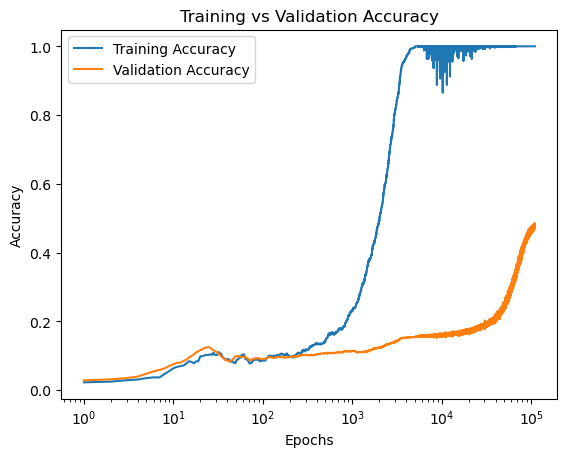

Epoch [120000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4849, Weight Norm: 59.1324:  24%|██▍       | 119999/500000 [57:43<2:57:23, 35.70it/s]

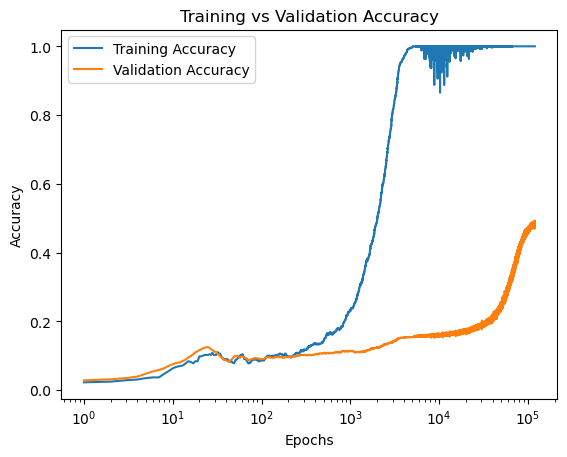

Epoch [130000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4826, Weight Norm: 57.2609:  26%|██▌       | 129996/500000 [1:02:38<3:14:18, 31.74it/s]

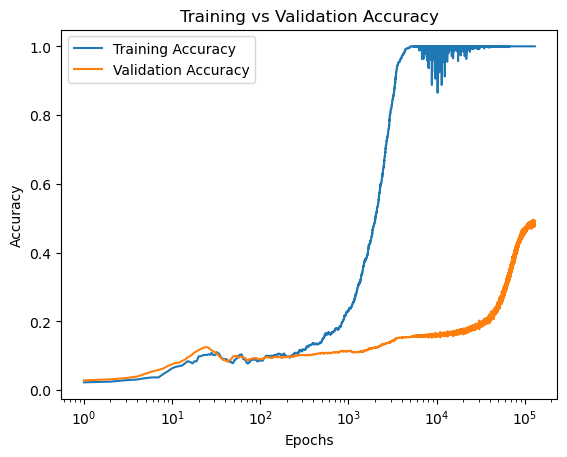

Epoch [140000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4838, Weight Norm: 56.0633:  28%|██▊       | 139998/500000 [1:07:22<3:02:41, 32.84it/s]

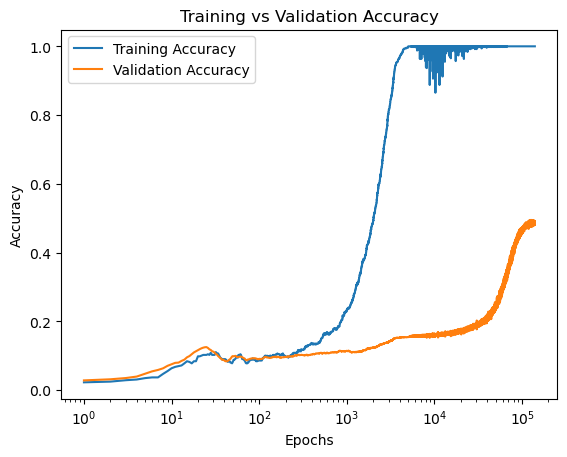

Epoch [150000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4840, Weight Norm: 55.0575:  30%|██▉       | 149996/500000 [1:11:52<3:05:12, 31.50it/s]

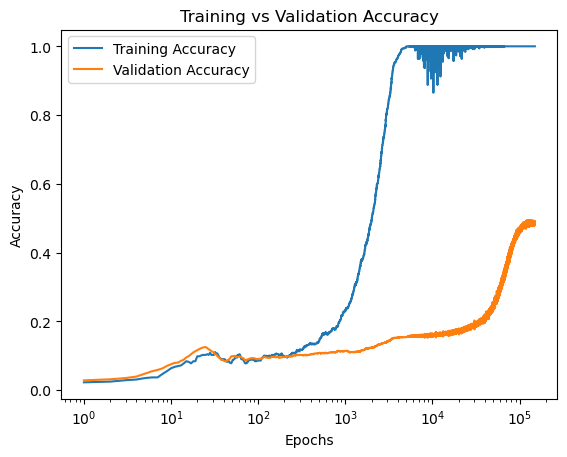

Epoch [160000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4838, Weight Norm: 54.2717:  32%|███▏      | 159996/500000 [1:16:24<2:41:03, 35.18it/s]

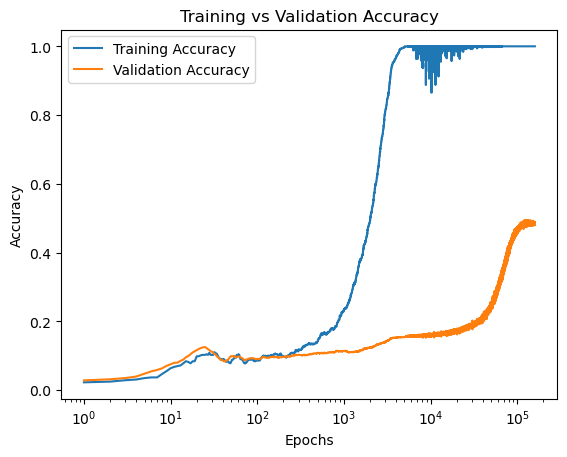

Epoch [170000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4817, Weight Norm: 53.7242:  34%|███▍      | 169999/500000 [1:20:56<2:15:37, 40.56it/s]

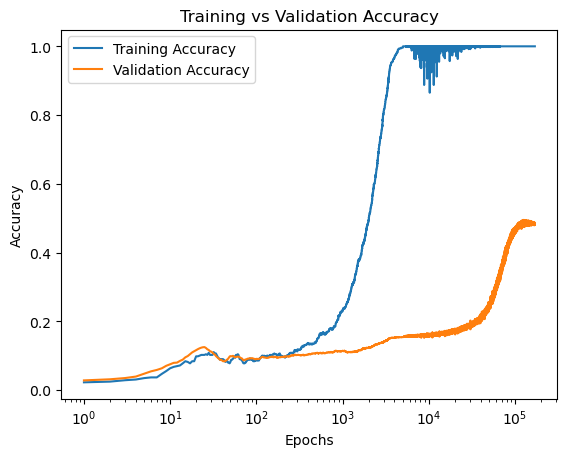

Epoch [180000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4822, Weight Norm: 53.2174:  36%|███▌      | 179995/500000 [1:25:28<2:46:42, 31.99it/s]

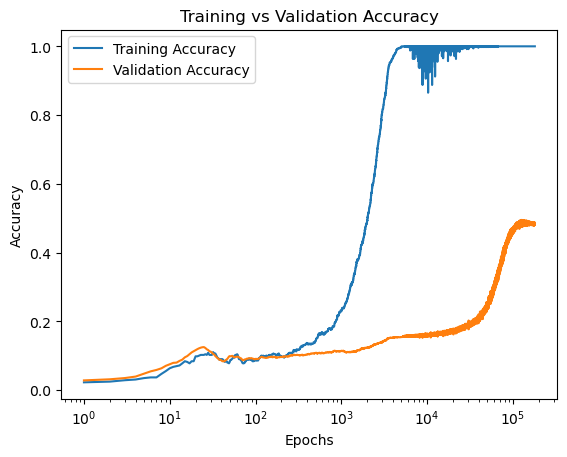

Epoch [190000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4799, Weight Norm: 53.0779:  38%|███▊      | 189999/500000 [1:30:00<2:45:58, 31.13it/s]

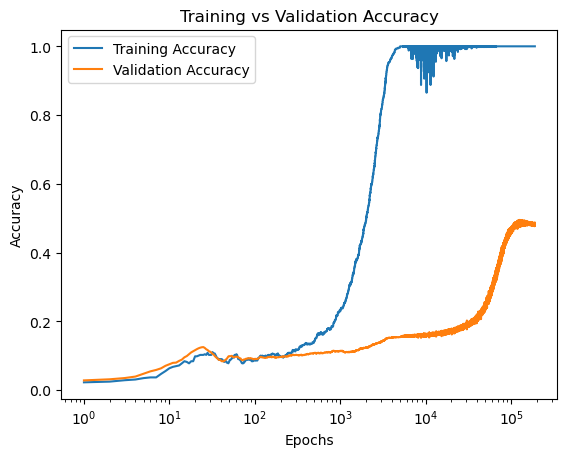

Epoch [200000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4792, Weight Norm: 52.8173:  40%|███▉      | 199998/500000 [1:34:30<2:56:49, 28.28it/s]

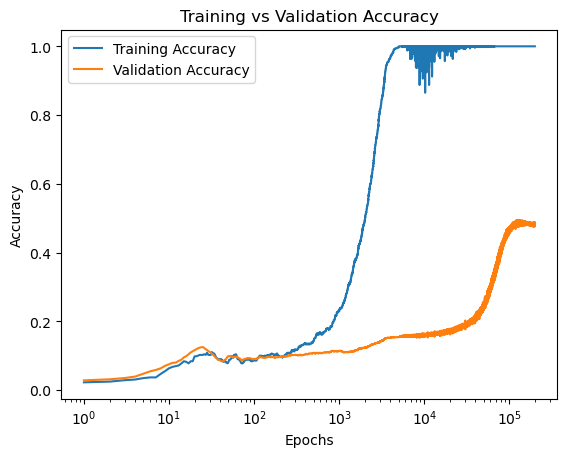

Epoch [210000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4824, Weight Norm: 52.6416:  42%|████▏     | 209995/500000 [1:39:02<2:05:40, 38.46it/s]

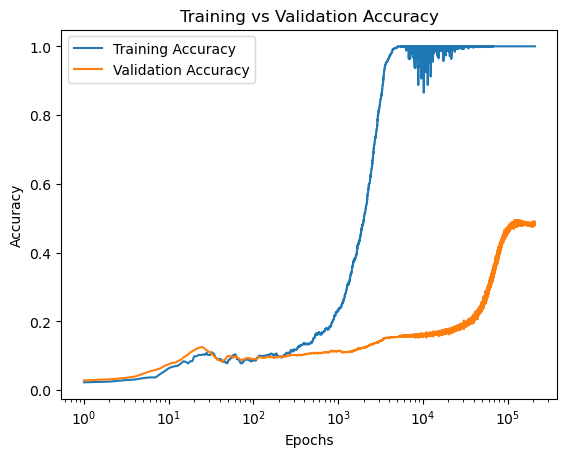

Epoch [220000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4831, Weight Norm: 52.7461:  44%|████▍     | 219999/500000 [1:43:30<1:52:32, 41.47it/s]

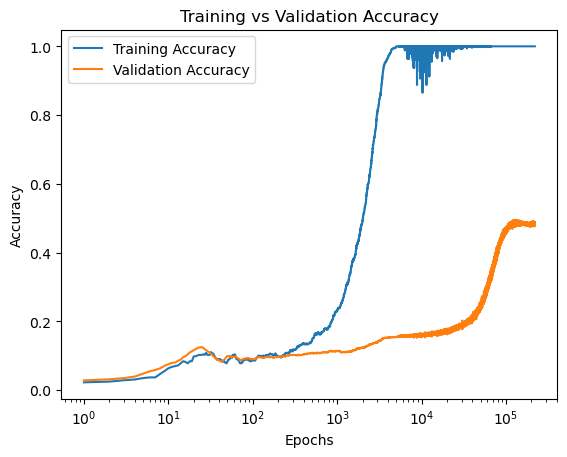

Epoch [230000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4849, Weight Norm: 52.3303:  46%|████▌     | 229997/500000 [1:48:20<2:10:33, 34.47it/s]

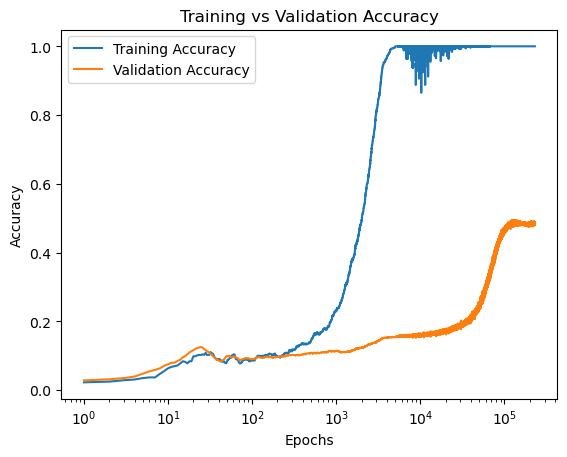

Epoch [240000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4861, Weight Norm: 52.3819:  48%|████▊     | 239999/500000 [1:53:15<2:24:37, 29.96it/s]

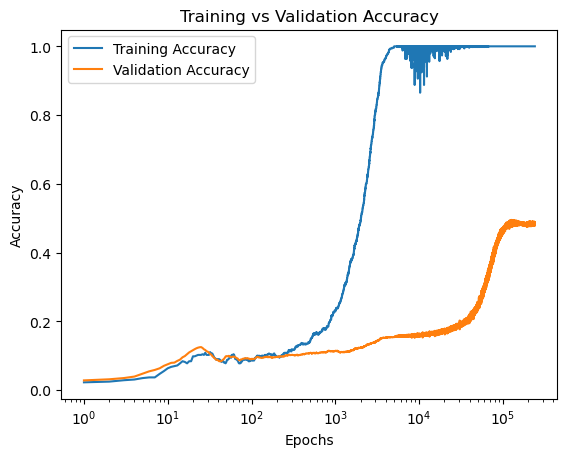

Epoch [250000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4847, Weight Norm: 52.2982:  50%|████▉     | 249997/500000 [1:58:05<1:54:03, 36.53it/s]

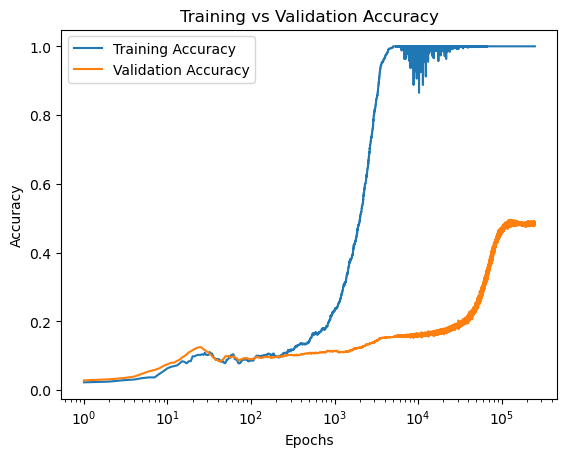

Epoch [260000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4858, Weight Norm: 52.2762:  52%|█████▏    | 259998/500000 [2:02:42<2:00:12, 33.28it/s]

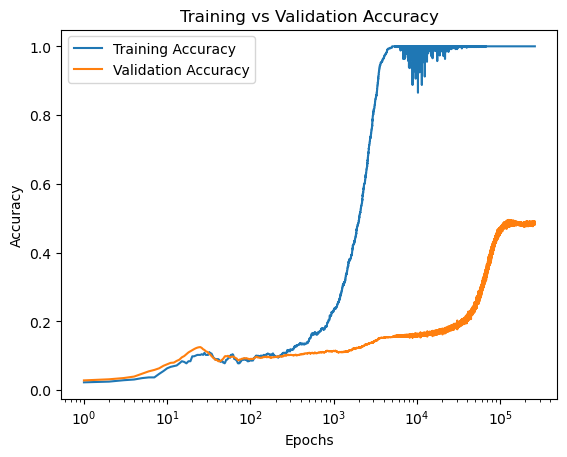

Epoch [270000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4876, Weight Norm: 52.1854:  54%|█████▍    | 269996/500000 [2:07:19<2:09:03, 29.70it/s]

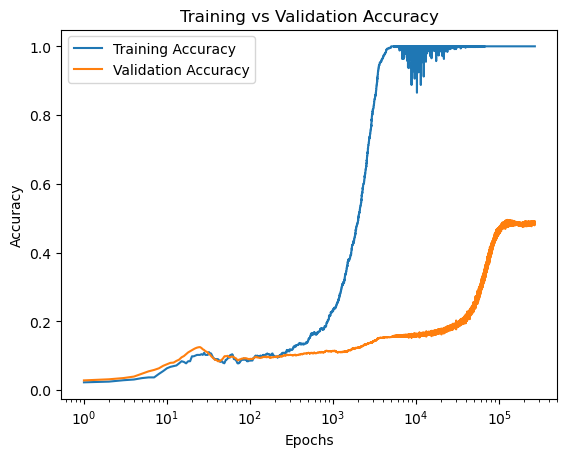

Epoch [280000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4876, Weight Norm: 52.0906:  56%|█████▌    | 279994/500000 [2:11:55<1:18:08, 46.93it/s]

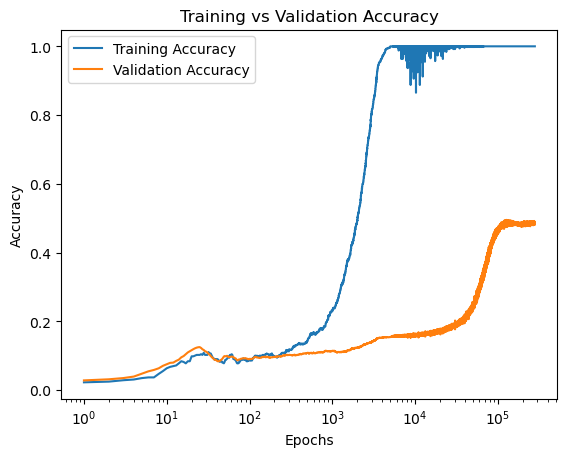

Epoch [290000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4858, Weight Norm: 52.1848:  58%|█████▊    | 289995/500000 [2:15:41<1:20:50, 43.29it/s]

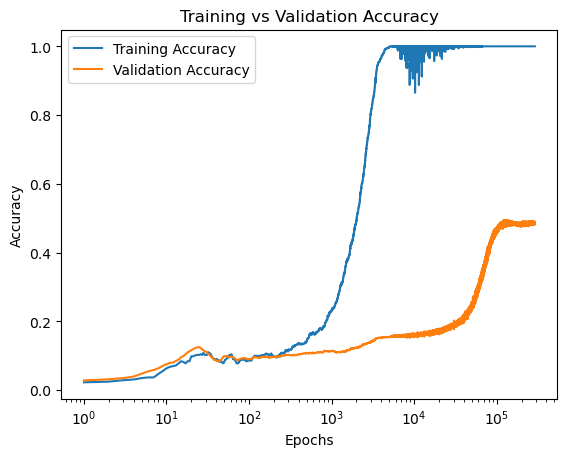

Epoch [300000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4872, Weight Norm: 52.0968:  60%|█████▉    | 299996/500000 [2:19:21<1:12:20, 46.07it/s]

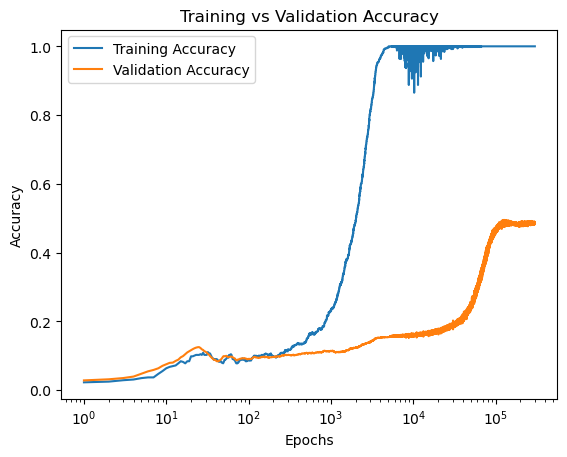

Epoch [310000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4865, Weight Norm: 52.0103:  62%|██████▏   | 309996/500000 [2:23:00<1:08:14, 46.41it/s]

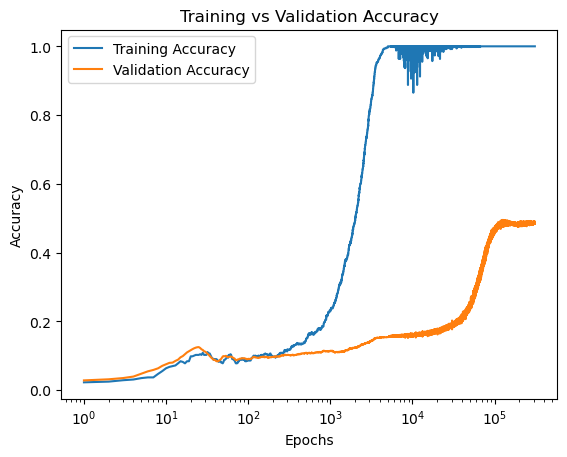

Epoch [320000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4881, Weight Norm: 52.1835:  64%|██████▍   | 319998/500000 [2:26:40<59:46, 50.18it/s]  

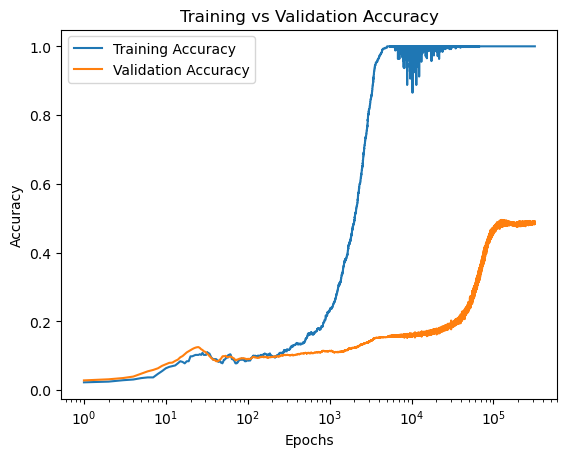

Epoch [330000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4890, Weight Norm: 51.9787:  66%|██████▌   | 329998/500000 [2:30:21<1:02:42, 45.18it/s]

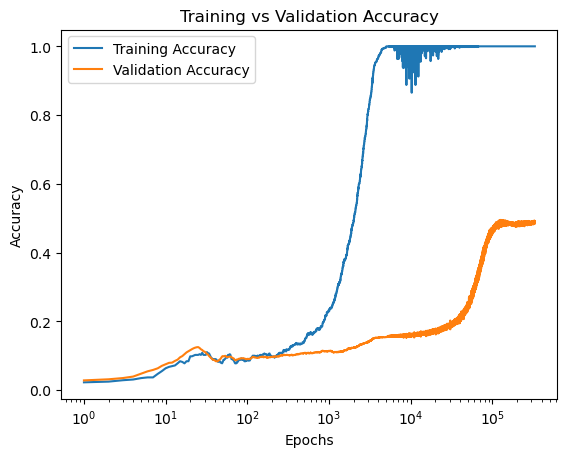

Epoch [340000/500000], Loss: 0.0001, Train Accuracy: 1.0000, Val Accuracy: 0.4917, Weight Norm: 51.8829:  68%|██████▊   | 339995/500000 [2:34:00<57:41, 46.22it/s]  

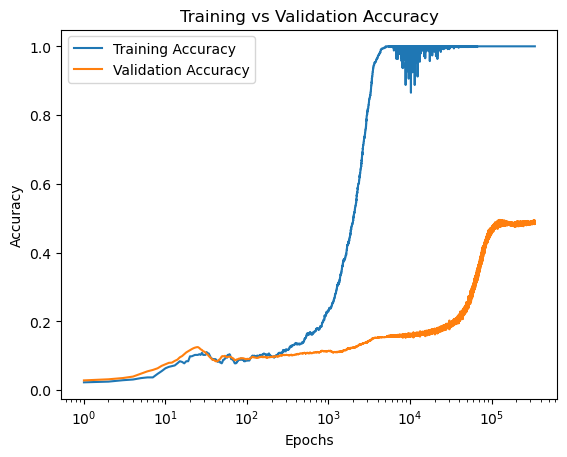

Epoch [350000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4858, Weight Norm: 51.9308:  70%|██████▉   | 349994/500000 [2:37:40<51:28, 48.57it/s]  

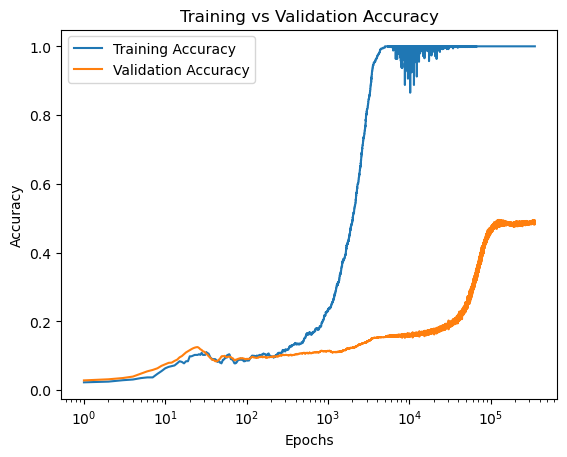

Epoch [360000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4888, Weight Norm: 51.9564:  72%|███████▏  | 359997/500000 [2:41:20<51:46, 45.07it/s]  

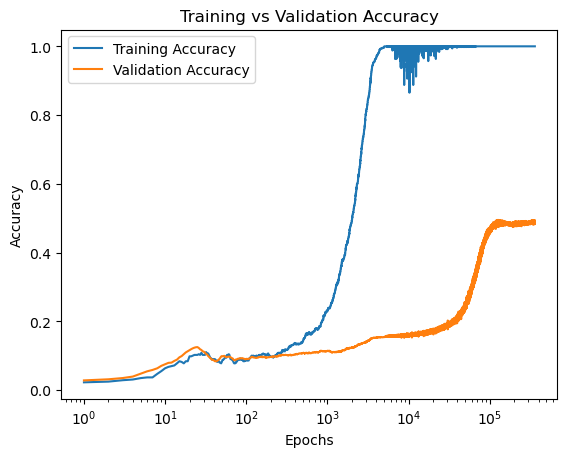

Epoch [370000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4854, Weight Norm: 51.9746:  74%|███████▍  | 369996/500000 [2:45:00<49:15, 43.98it/s]  

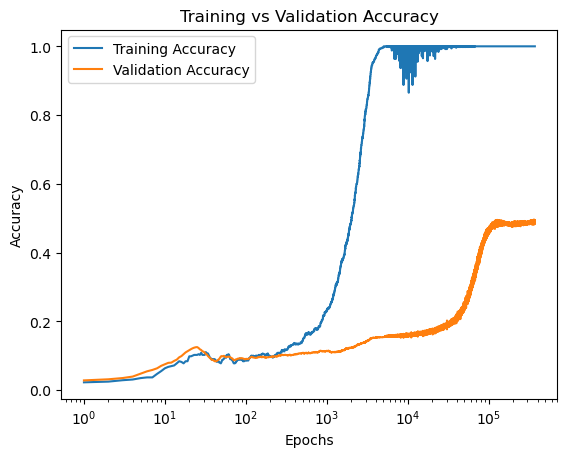

Epoch [380000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4901, Weight Norm: 51.8980:  76%|███████▌  | 379995/500000 [2:48:41<39:16, 50.93it/s]  

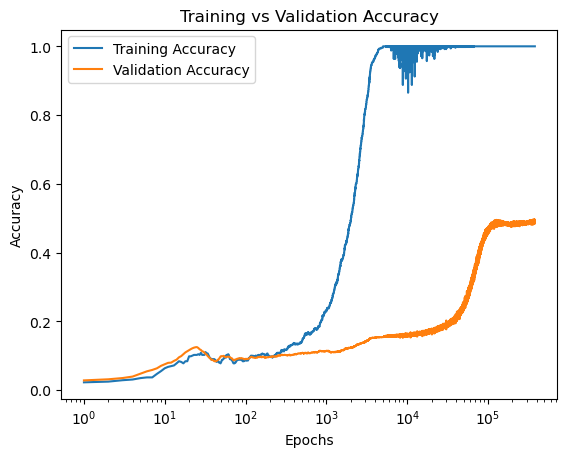

Epoch [390000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4929, Weight Norm: 51.8946:  78%|███████▊  | 389995/500000 [2:52:21<41:25, 44.26it/s]  

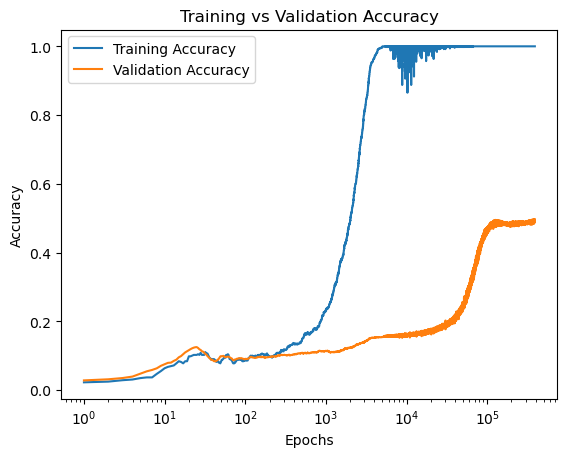

Epoch [400000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4924, Weight Norm: 51.8967:  80%|███████▉  | 399997/500000 [2:56:02<37:09, 44.86it/s]  

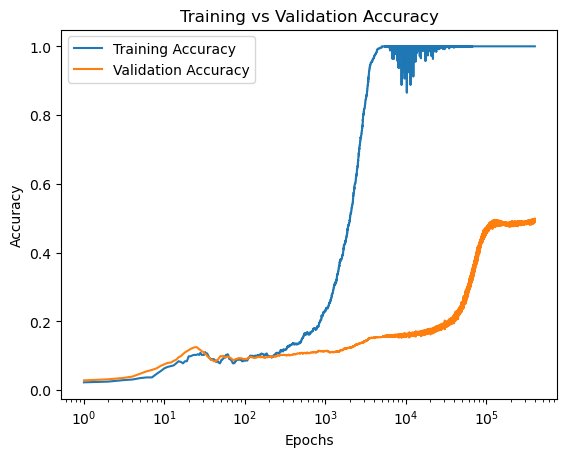

Epoch [410000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4940, Weight Norm: 52.0771:  82%|████████▏ | 409997/500000 [2:59:43<30:12, 49.64it/s]  

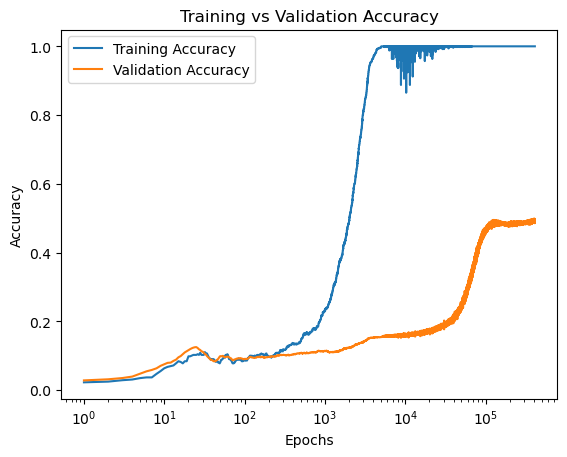

Epoch [420000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4929, Weight Norm: 51.9048:  84%|████████▍ | 419997/500000 [3:03:25<33:15, 40.10it/s]  

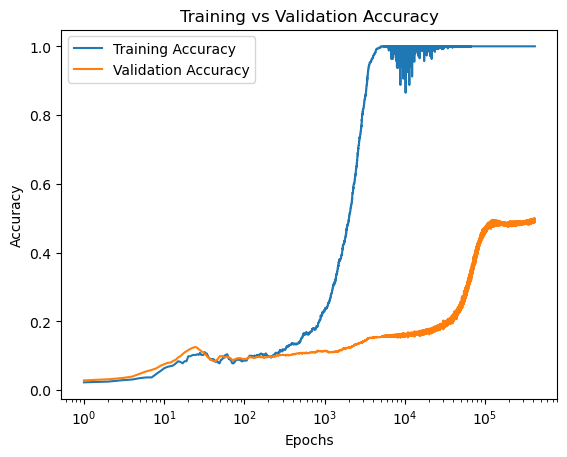

Epoch [430000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4931, Weight Norm: 51.9671:  86%|████████▌ | 429994/500000 [3:07:06<24:59, 46.69it/s]  

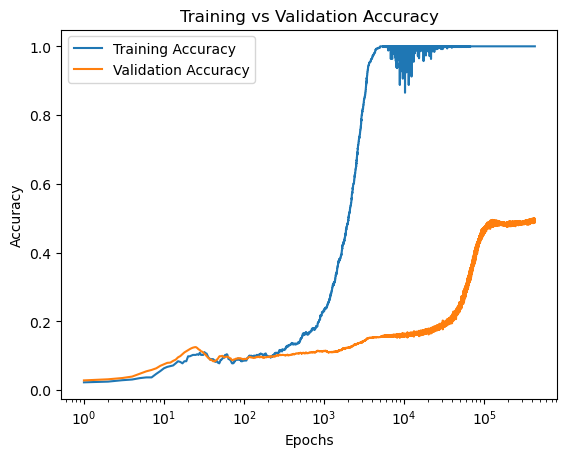

Epoch [440000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4933, Weight Norm: 51.8934:  88%|████████▊ | 439997/500000 [3:10:49<22:34, 44.29it/s]

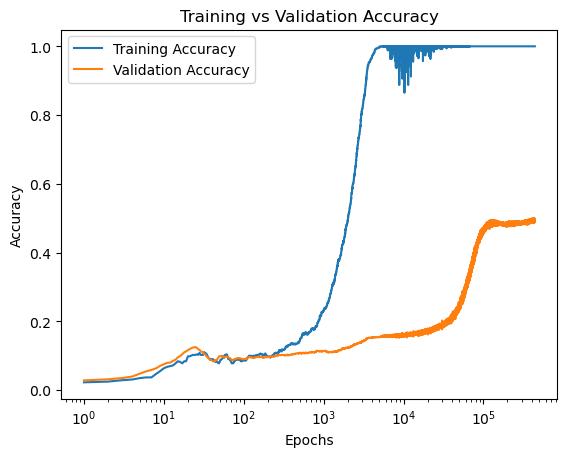

Epoch [450000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4926, Weight Norm: 51.8224:  90%|████████▉ | 449999/500000 [3:14:31<18:10, 45.85it/s]

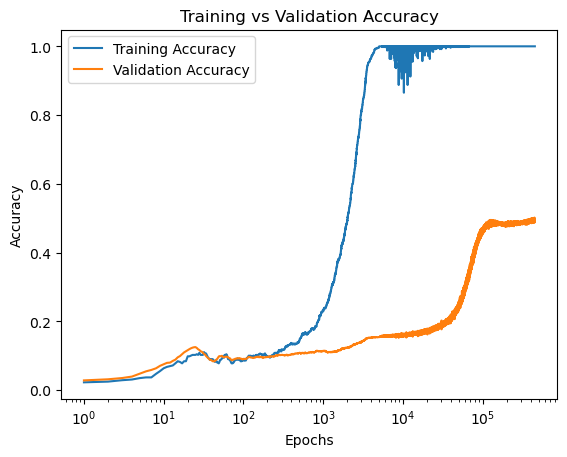

Epoch [460000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4910, Weight Norm: 51.5469:  92%|█████████▏| 459999/500000 [3:18:14<13:30, 49.38it/s]

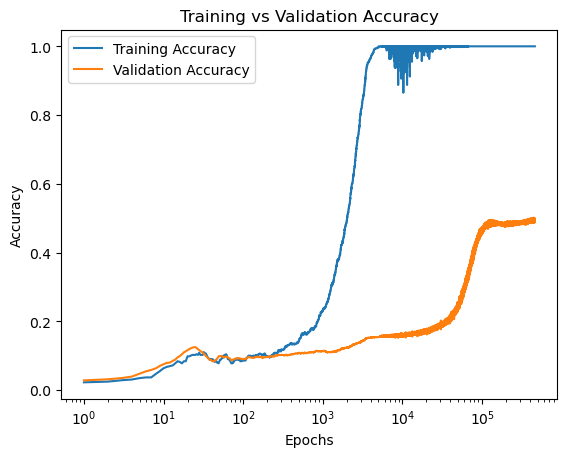

Epoch [470000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4954, Weight Norm: 51.9933:  94%|█████████▍| 469999/500000 [3:21:57<13:46, 36.30it/s]

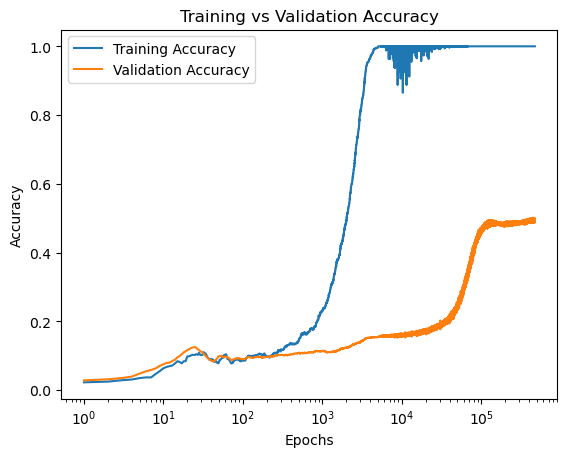

Epoch [480000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4951, Weight Norm: 51.6180:  96%|█████████▌| 479998/500000 [3:25:41<06:49, 48.79it/s]

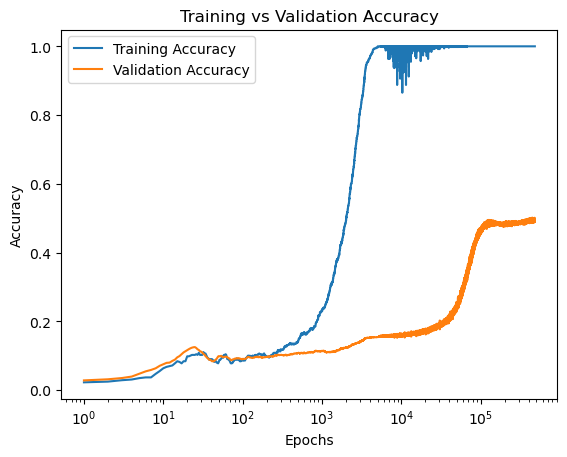

Epoch [490000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4938, Weight Norm: 51.5172:  98%|█████████▊| 489998/500000 [3:29:24<03:39, 45.51it/s]

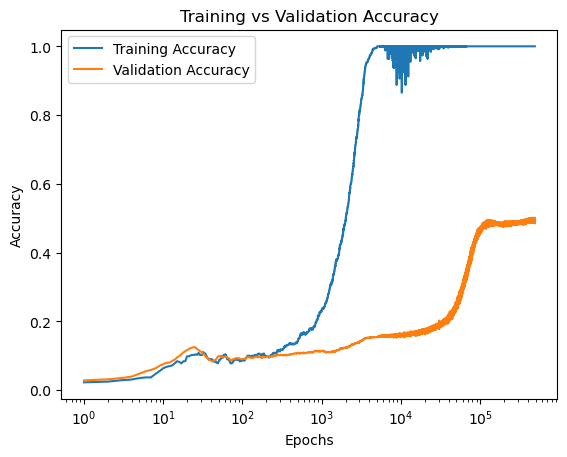

Epoch [500000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4929, Weight Norm: 51.3104: 100%|█████████▉| 499997/500000 [3:33:08<00:00, 48.66it/s]

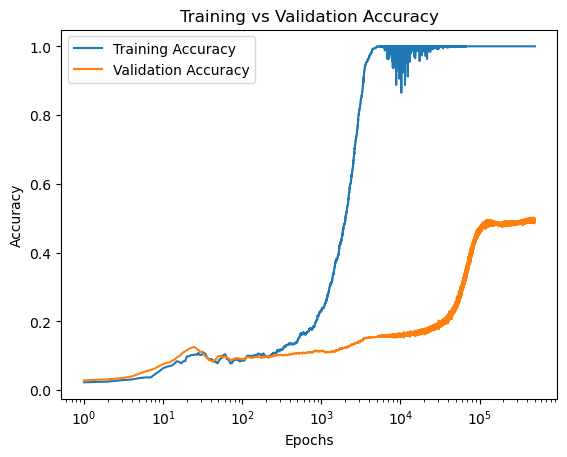

Epoch [500000/500000], Loss: 0.0000, Train Accuracy: 1.0000, Val Accuracy: 0.4929, Weight Norm: 51.3104: 100%|██████████| 500000/500000 [3:33:08<00:00, 39.10it/s]


In [5]:
#Training

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

train_acc = []
val_acc = []
train_loss = []
weight_normlist = []

#Loop
bar = tqdm(range(epochs))
for epoch in bar:
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        labels_one_hot = F.one_hot((labels).long(), 10).float()
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate Train Accuracy
    _, predicted = torch.max(outputs.data, 1)
    correct_train += (predicted == labels).sum().item()
    total_train += labels.size(0)
    train_accuracy = correct_train / total_train
    train_acc.append(train_accuracy)
    
    # Store loss
    train_loss.append(loss.item())
    
    # Calculate Validation Accuracy
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for x, labels in test_loader:
            y = model(x)
            _, predicted = torch.max(y, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_acc.append(val_accuracy)

    # Calculate Weight Norm
    weight_norm = sum(p.norm().item() for p in model.parameters())
    weight_normlist.append(weight_norm)
    
    # Print progress
    bar.set_description(f'Epoch [{epoch+1}/{epochs}], Loss: {loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Weight Norm: {weight_norm:.4f}')
    
    # Plot graph every 50,000 epochs
    if (epoch + 1) % 10000 == 0:
        import matplotlib.pyplot as plt
        plt.xscale("log")
        plt.plot(range(1, epoch + 2), train_acc, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), val_acc, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training vs Validation Accuracy')
        plt.legend()
        plt.show()


In [6]:
#Evaluate
model.eval()
total = 0
correct = 0
one_hots = torch.eye(10, 10)
with torch.no_grad():
        for x, labels in test_loader:
            y = model(x)
            _, predicted = torch.max(y,1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)


print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 49.29%


In [7]:
import matplotlib.pyplot as plt

# Function to display images and predictions
def display_predictions(model, testloader, num_images=5):
    model.eval()
    images, labels = next(iter(testloader))
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].numpy().squeeze(), cmap='gray')
        ax.set_title(f'Pred: {predicted[i].item()}')
        ax.axis('off')
    plt.show()

# Evaluate the model
model.eval()
correct = 0
total = 0
one_hots = torch.eye(10, 10)

with torch.no_grad():
    for x, labels in test_loader:
        y = model(x)
        _, predicted = torch.max(y, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f'Accuracy: {100 * accuracy:.2f}%')

# Display example predictions
#display_predictions(model, test_loader, num_images=5)


Accuracy: 49.29%


"#Training\n\ncriterion = nn.MSELoss()\noptimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)\n\ntrain_acc = []\nval_acc = []\ntrain_loss = []\nweight_normlist = []\n\n#Loop\nbar = tqdm(range(epochs))\nfor epoch in bar:\n    model.train()\n    running_loss = 0.0\n    correct_train = 0\n    total_train = 0\n    \n    for images, labels in train_loader:\n        optimizer.zero_grad()\n        outputs = model(images)\n        labels_one_hot = F.one_hot(labels, 10).float()\n        loss = criterion(outputs, labels_one_hot)\n        loss.backward()\n        optimizer.step()\n        running_loss += loss.item()\n\n    #Calculate Train Accuracy\n    _, predicted = torch.max(outputs.data, 1)\n    correct_train += (predicted == labels).sum().item()\n    total_train += labels.size(0)\n    train_accuracy = correct_train / total_train\n    train_acc.append(train_accuracy)\n    #Store loss\n    train_loss.append(loss)\n    #Calculate Validation Accuracy\n    model.eval()\n    tot